# 4. k 최근접 이웃(KNN)
- 특별한 예측 모델 없이 가장 가까운 데이터 포인트를 기반으로 예측을 수행하는 방법
    - 주변 이웃들이 테스트 포인트에 얼마나 가까운지에 따라서 예측을 수행
- 표준화 or 정규화가 필요
    - A변수와 B변수의 분포가 다른데, 이렇게 분포가 다르면 각 변수의 차이를 해석하기 어렵기 때문(A: 0 ~ 1,000,000 / B: 0 ~ 10)
    - 변수 값을 표준 범위로 재조정하기 위해 표준화 or 정규화 수행
- 분류와 회귀 모두 지원

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
plt.style.use(["seaborn-whitegrid"])

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.datasets import load_breast_cancer, load_iris, load_wine, fetch_california_housing
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

/var/folders/79/v97_0rqs3p34z9xx6y57xks80000gn/T/ipykernel_1329/36687497.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(["seaborn-whitegrid"])


## k 최근접 이웃 분류
- 입력 데이터 포인트와 가장 가까운 k개의 훈련 데이터 포인트가 출력
- k개의 데이터 포인트 중 가장 많은 클래스가 예측 결과
    - ![](images/2023-04-12-15-20-58.png)

### 붓꽃 데이터

In [2]:
# 붓꽃 데이터 불러오기
iris = load_iris()

# 데이터프레임으로 만들기
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
species = pd.Series(iris.target, dtype="category")
species = species.cat.rename_categories(iris.target_names)
iris_df["Target"] = species
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


- KNeighborsClassifier 모델 학습

In [3]:
# 학습/테스트 데이터 셋 분리
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# 데이터 표준화(전처리)
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

# KNeighborsClassifier 학습
model = KNeighborsClassifier()
model.fit(X_train, y_train)

# 모델 평가
print("학습 데이터 점수: {}".format(model.score(X_train, y_train)))
print("평가 데이터 점수: {}".format(model.score(X_test, y_test)))

# 표준화된 데이터로 KNeighborsClassifier 학습
model = KNeighborsClassifier()
model.fit(X_train_scale, y_train)

# 모델 평가
print("표준화된 학습 데이터 점수: {}".format(model.score(X_train_scale, y_train)))
print("표준화된 평가 데이터 점수: {}".format(model.score(X_test_scale, y_test)))

학습 데이터 점수: 0.9583333333333334
평가 데이터 점수: 1.0
표준화된 학습 데이터 점수: 0.9583333333333334
표준화된 평가 데이터 점수: 0.9666666666666667


- 교차검증 수행

In [4]:
# make_pipeline으로 estimator(객체) 생성
estimator = make_pipeline(StandardScaler(),
                          KNeighborsClassifier())

# cross_validate으로 교차검증 수행
cross_validate(estimator=estimator,
               X=X, y=y,
               verbose=True,
               n_jobs=multiprocessing.cpu_count(),
               cv=5)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    1.0s finished


{'fit_time': array([0.00128198, 0.00144672, 0.00110698, 0.0012188 , 0.00141907]),
 'score_time': array([0.00154924, 0.00166988, 0.00178194, 0.00216126, 0.00171995]),
 'test_score': array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ])}

- GridSearchCV 수행

In [5]:
# 파라미터 후보군
param_grid = {"n_neighbors": [3, 5, 7],
              "weights": ["uniform", "distance"],
              "algorithm": ["ball_tree", "kd_tree", "brute"]}

# GridSearchCV 수행
gs = GridSearchCV(estimator=KNeighborsClassifier(),
                  param_grid=param_grid,
                  n_jobs=multiprocessing.cpu_count(),
                  verbose=True)
gs.fit(X, y)

# 최적의 파라미터
print(gs.best_params_)

# 최적의 모델의 점수
print("GridSearchCV best score: {}".format(gs.best_score_))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
{'algorithm': 'ball_tree', 'n_neighbors': 7, 'weights': 'uniform'}
GridSearchCV best score: 0.9800000000000001


- 시각화

In [6]:
# 격자 그리드 형태 데이터들을 생성할 함수
def get_meshgrid(x, y, h=0.02):
    xx, yy = np.meshgrid(np.arange(x.min()-1, x.max()+1, h), np.arange(y.min()-1, y.max()+1, h))
    return xx, yy

# 그래프에 각 클래스에 대한 영역을 구분해줄 함수
def get_contourf(clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    return plt.contourf(xx, yy, Z, **params)

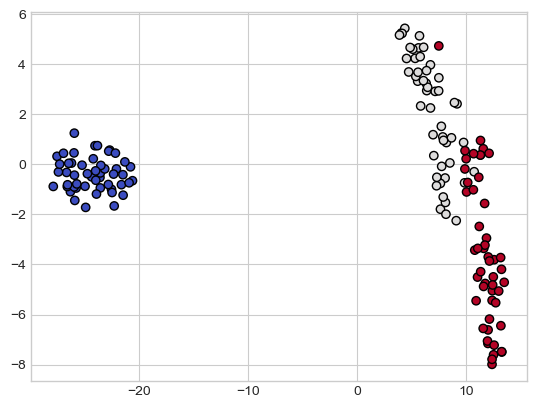

In [7]:
# 그래프에 나타내기 위해 데이터 차원 축소
tsne = TSNE(n_components=2)
X_comp = tsne.fit_transform(X)

# 차원 축소한 데이터들 데이터프레임으로 만들기
iris_comp_df = pd.DataFrame(X_comp)
iris_comp_df["Target"] = y

# 각 클래스를 시각화
plt.scatter(X_comp[:, 0], X_comp[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors="k");

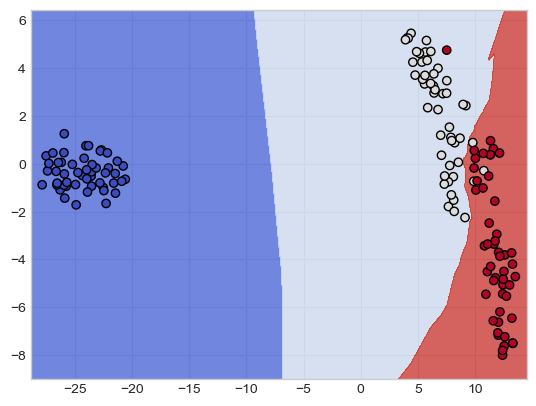

In [8]:
# 차원 축소한 데이터들로 KNeighborsClassifier 학습
model = KNeighborsClassifier()
model.fit(X_comp, y)

# 각 클래스의 영역을 구분할 데이터들을 생성
xx, yy = get_meshgrid(X_comp[:, 0], X_comp[:, 1])

# 영역을 구분할 데이터들을 분류 및 영역 구분
get_contourf(model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)

# 분류된 데이터들을 산점도로 시각화
plt.scatter(X_comp[:, 0], X_comp[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors="k");

### 유방암 데이터

In [39]:
# 유방암 데이터 불러오기
cancer = load_breast_cancer()

# 데이터프레임으로 만들기
cancer_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
cancer_df["Target"] = cancer.target
cancer_df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


- KNeighborsClassifier 모델 학습

In [40]:
# 학습/테스트 데이터 셋 분리
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# 데이터 표준화(전처리)
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

# KNeighborsClassifier 학습
model = KNeighborsClassifier()
model.fit(X_train, y_train)

# 모델 평가
print("학습 데이터 점수: {}".format(model.score(X_train, y_train)))
print("평가 데이터 점수: {}".format(model.score(X_test, y_test)))

# 표준화된 데이터로 KNeighborsClassifier 학습
model = KNeighborsClassifier()
model.fit(X_train_scale, y_train)
y_predict = model.predict(X_test_scale)

# 모델 평가
print("표준화된 학습 데이터 점수: {}".format(model.score(X_train_scale, y_train)))
print("표준화된 평가 데이터 점수: {}".format(model.score(X_test_scale, y_test)))

학습 데이터 점수: 0.9472527472527472
평가 데이터 점수: 0.9385964912280702
표준화된 학습 데이터 점수: 0.9824175824175824
표준화된 평가 데이터 점수: 0.956140350877193


- 교차검증 수행

In [41]:
# make_pipeline으로 estimator(객체) 생성
estimator = make_pipeline(StandardScaler(),
                          KNeighborsClassifier())

# cross_validate으로 교차검증 수행
cross_validate(estimator=estimator,
               X=X, y=y,
               verbose=True,
               n_jobs=multiprocessing.cpu_count())

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    1.0s finished


{'fit_time': array([0.00185704, 0.00115323, 0.00127196, 0.00171208, 0.00160575]),
 'score_time': array([0.02714014, 0.02370405, 0.02476096, 0.02601004, 0.02668524]),
 'test_score': array([0.96491228, 0.95614035, 0.98245614, 0.95614035, 0.96460177])}

- GridSearchCV 수행

In [42]:
# Pipeline으로 pipe(객체) 생성
pipe = Pipeline([("scaler", StandardScaler()),
                 ("model", KNeighborsClassifier())])

# 파라미터 후보군
param_grid = {"model__n_neighbors": [3, 5, 7],
              "model__weights": ["uniform", "distance"],
              "model__algorithm": ["ball_tree", "kd_tree", "brute"]}

# GridSearchCV 수행
gs = GridSearchCV(estimator=pipe,
                  param_grid=param_grid,
                  verbose=True,
                  n_jobs=multiprocessing.cpu_count())
gs.fit(X, y)

# 최적의 파라미터
print(gs.best_params_)

# 최적의 모델의 점수
print("GridSearchCV best score: {}".format(gs.best_score_))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
{'model__algorithm': 'ball_tree', 'model__n_neighbors': 7, 'model__weights': 'uniform'}
GridSearchCV best score: 0.9701288619779538


- 시각화

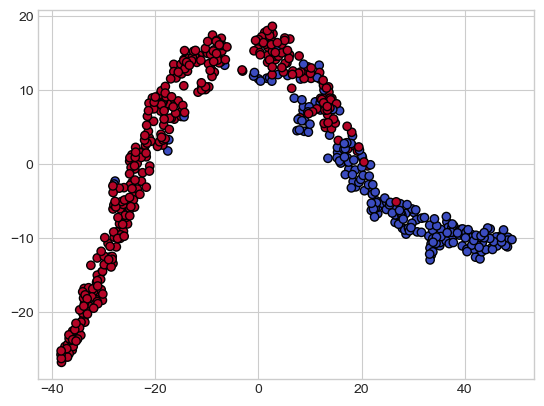

In [43]:
# 그래프에 나타내기 위해 데이터 차원 축소
tsne = TSNE(n_components=2)
X_comp = tsne.fit_transform(X)

# 차원 축소한 데이터들 데이터프레임으로 만들기
cancer_comp_df = pd.DataFrame(X_comp)
cancer_comp_df["Target"] = y

# 각 클래스를 시각화
plt.scatter(X_comp[:, 0], X_comp[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors="k");

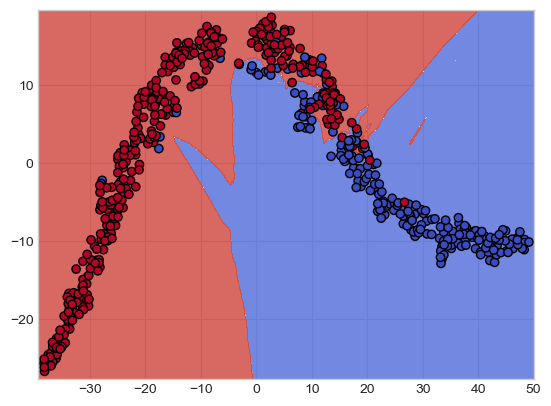

In [14]:
# 차원 축소한 데이터들로 KNeighborsClassifier 학습
model = KNeighborsClassifier()
model.fit(X_comp, y)

# 각 클래스의 영역을 구분할 데이터들을 생성
xx, yy = get_meshgrid(X_comp[:, 0], X_comp[:, 1])

# 영역을 구분할 데이터들을 분류 및 영역 구분
get_contourf(model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)

# 분류된 데이터들을 산점도로 시각화
plt.scatter(X_comp[:, 0], X_comp[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors="k");

[[37  5]
 [ 0 72]]


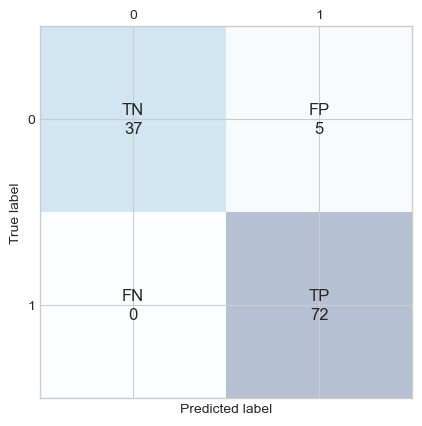

In [46]:
# Confusion Matrix
confmat = confusion_matrix(y_test, y_predict)
print(confmat)

# 시각화
confmat_list = ["TN", "FP", "FN", "TP"]
confmat_list = np.array(confmat_list).reshape(2, 2)
ax = plt.subplot()
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(2):
    for j in range(2):
        ax.text(x=j, y=i - 0.05, s=confmat_list[i, j], fontsize=12, ha="center", va="center")
        ax.text(x=j, y=i + 0.05, s=confmat[i, j], fontsize=12, ha="center", va="center")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()

### 와인 데이터

In [16]:
# 와인 데이터 불러오기
wine = load_wine()

# 데이터프레임으로 만들기
wine_df = pd.DataFrame(wine.data, columns=wine.feature_names)
types = pd.Series(wine.target, dtype="category")
types = types.cat.rename_categories(wine.target_names)
wine_df["Target"] = types
wine_df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,class_0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,class_0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,class_0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,class_0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,class_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,class_2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,class_2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,class_2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,class_2


- KNeighborsClassifier 모델 학습

In [17]:
# 학습/테스트 데이터 셋 분리
X, y = load_wine(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# 데이터 표준화(전처리)
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

# KNeighborsClassifier 학습
model = KNeighborsClassifier()
model.fit(X_train, y_train)

# 모델 평가
print("학습 데이터 점수: {}".format(model.score(X_train, y_train)))
print("평가 데이터 점수: {}".format(model.score(X_test, y_test)))

# 표준화된 데이터로 KNeighborsClassifier 학습
model = KNeighborsClassifier()
model.fit(X_train_scale, y_train)

# 모델 평가
print("표준화된 학습 데이터 점수: {}".format(model.score(X_train_scale, y_train)))
print("표준화된 평가 데이터 점수: {}".format(model.score(X_test_scale, y_test)))

학습 데이터 점수: 0.823943661971831
평가 데이터 점수: 0.6388888888888888
표준화된 학습 데이터 점수: 0.9788732394366197
표준화된 평가 데이터 점수: 0.9722222222222222


- 교차검증 수행

In [18]:
# make_pipeline으로 estimator(객체) 생성
estimator = make_pipeline(StandardScaler(),
                          KNeighborsClassifier())

# cross_validate으로 교차검증 수행
cross_validate(estimator=estimator,
               X=X, y=y,
               n_jobs=multiprocessing.cpu_count(),
               verbose=True)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    0.0s finished


{'fit_time': array([0.00106978, 0.00079322, 0.00086713, 0.00090694, 0.00079799]),
 'score_time': array([0.00167608, 0.00164604, 0.00142694, 0.00136805, 0.00136399]),
 'test_score': array([0.94444444, 0.94444444, 0.97222222, 1.        , 0.88571429])}

- GridSearchCV 수행

In [19]:
# Pipeline으로 pipe(객체) 생성
pipe = Pipeline([("scaler", StandardScaler()),
                 ("model", KNeighborsClassifier())])

# 파라미터 후보군
param_grid = {"model__n_neighbors": [3, 5, 7],
              "model__weights": ["uniform", "distance"],
              "model__algorithm": ["ball_tree", "kd_tree", "brute"]}

# GridSearchCV 수행
gs = GridSearchCV(estimator=pipe,
                  param_grid=param_grid,
                  verbose=True,
                  n_jobs=multiprocessing.cpu_count())
gs.fit(X, y)

# 최적의 파라미터
print(gs.best_params_)

# 최적의 모델의 점수
print("GridSearchCV best score: {}".format(gs.best_score_))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
{'model__algorithm': 'ball_tree', 'model__n_neighbors': 7, 'model__weights': 'uniform'}
GridSearchCV best score: 0.9665079365079364


- 시각화

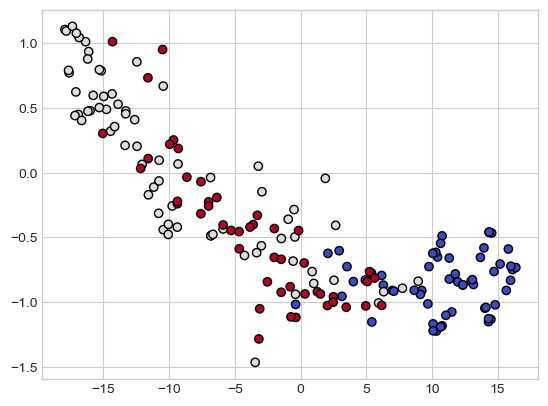

In [20]:
# 그래프에 나타내기 위해 데이터 차원 축소
tsne = TSNE(n_components=2)
X_comp = tsne.fit_transform(X)

# 각 클래스를 시각화
plt.scatter(X_comp[:, 0], X_comp[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors="k");

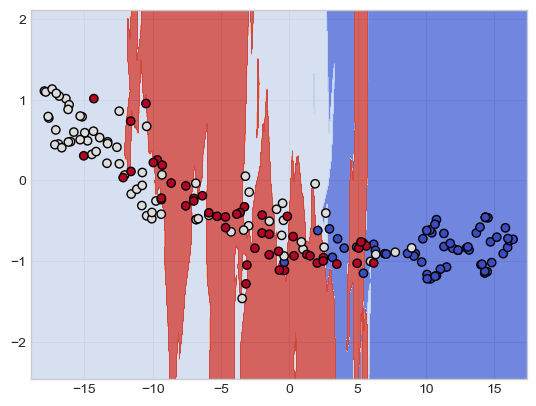

In [21]:
# 차원 축소한 데이터들로 KNeighborsClassifier 학습
model = KNeighborsClassifier()
model.fit(X_comp, y)

# 각 클래스의 영역을 구분할 데이터들을 생성
xx, yy = get_meshgrid(X_comp[:, 0], X_comp[:, 1])

# 영역을 구분할 데이터들을 분류 및 영역 구분
get_contourf(model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)

# 분류된 데이터들을 산점도로 시각화
plt.scatter(X_comp[:, 0], X_comp[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors="k");

## k 최근접 이웃 회귀
- k 최근접 이웃 분류와 마찬가지로 예측에 이웃 데이터 포인트 사용
- 이웃 데이터 포인트의 평균이 예측 결과

### 보스턴 주택 가격

In [22]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

boston_df = pd.DataFrame(data)
boston_df["Target"] = target
boston_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,Target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


- KNeighborsRegressor 모델 학습

In [23]:
# 학습/테스트 데이터 셋 분리
X, y = data, target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# 데이터 표준화(전처리)
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

# KNeighborsRegressor 학습
model = KNeighborsRegressor()
model.fit(X_train, y_train)

# 모델 평가
print("학습 데이터 점수: {}".format(model.score(X_train, y_train)))
print("평가 데이터 점수: {}".format(model.score(X_test, y_test)))

# 표준화된 데이터로 KNeighborsClassifier 학습
model = KNeighborsRegressor()
model.fit(X_train_scale, y_train)

# 모델 평가
print("표준화된 학습 데이터 점수: {}".format(model.score(X_train_scale, y_train)))
print("표준화된 평가 데이터 점수: {}".format(model.score(X_test_scale, y_test)))

학습 데이터 점수: 0.6836784354854921
평가 데이터 점수: 0.5401612153026705
표준화된 학습 데이터 점수: 0.8336763909212733
표준화된 평가 데이터 점수: 0.8105457731109476


- 교차검증 수행

In [24]:
# make_pipeline으로 estimator(객체) 생성
estimator = make_pipeline(StandardScaler(),
                          KNeighborsRegressor())

# cross_validate으로 교차검증 수행
cross_validate(estimator=estimator,
               X=X, y=y,
               n_jobs=multiprocessing.cpu_count(),
               verbose=True)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    0.0s finished


{'fit_time': array([0.00099611, 0.00111699, 0.00079513, 0.0008378 , 0.00078392]),
 'score_time': array([0.00111294, 0.00115991, 0.00091076, 0.00095606, 0.00079107]),
 'test_score': array([0.56089547, 0.61917359, 0.48661916, 0.46986886, 0.23133037])}

- GridSearchCV 수행

In [25]:
# Pipeline으로 pipe(객체) 생성
pipe = Pipeline([("scaler", StandardScaler()),
                 ("model", KNeighborsRegressor())])

# 파라미터 후보군
param_grid = {"model__n_neighbors": [3, 5, 7],
              "model__weights": ["uniform", "distance"],
              "model__algorithm": ["brute", "ball_tree", "kd_tree"]}

# GridSearchCV 수행
gs = GridSearchCV(estimator=pipe,
                  param_grid=param_grid,
                  verbose=True,
                  n_jobs=multiprocessing.cpu_count())
gs.fit(X, y)

# 최적의 파라미터
print(gs.best_params_)

# 최적의 점수
print("GridSearchCV best score: {}".format(gs.best_score_))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
{'model__algorithm': 'brute', 'model__n_neighbors': 7, 'model__weights': 'distance'}
GridSearchCV best score: 0.4973060611762845


- 시각화

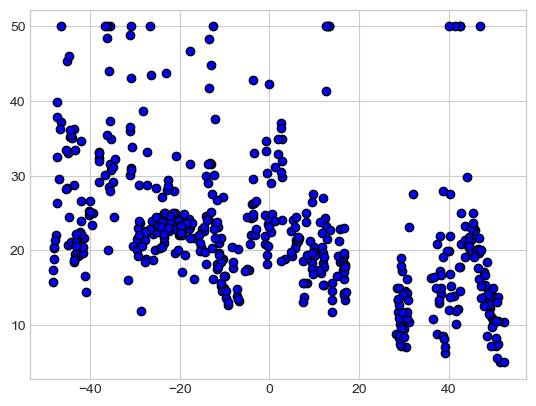

In [26]:
# 그래프에 나타내기 위해 데이터 차원 축소
tsne = TSNE(n_components=1)
X_comp = tsne.fit_transform(X)

# 실제 주택 가격 시각화
plt.scatter(X_comp, y, edgecolors="k", c="b");

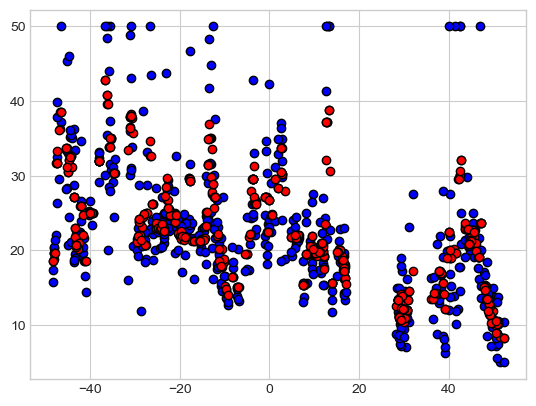

In [27]:
# 차원 축소한 데이터 KNeighborsRegressor 학습
model = KNeighborsRegressor()
model.fit(X_comp, y)
y_predict = model.predict(X_comp)

# 실제 주택 가격
plt.scatter(X_comp, y, edgecolors="k", c="b");

# 예측 주택 가격
plt.scatter(X_comp, y_predict, edgecolors="k", c="r");

### 캘리포니아 주택 가격

In [29]:
# 캘리포니아 주택 가격 데이터 불러오기
california = fetch_california_housing()

# 데이터프레임으로 만들기
california_df = pd.DataFrame(california.data, columns=california.feature_names)
california_df["Target"] = california.target
california_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


- KNeighborsRegressor 모델 학습

In [31]:
# 학습/테스트 데이터 셋 분리
X, y = california.data, california.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# 데이터 표준화(전처리)
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

# KNeighborsRegressor 학습
model = KNeighborsRegressor()
model.fit(X_train, y_train)

# 모델 평가
print("학습 데이터 점수: {}".format(model.score(X_train, y_train)))
print("평가 데이터 점수: {}".format(model.score(X_test, y_test)))

# 표준화된 데이터로 KNeighborsRegressor 학습
model = KNeighborsRegressor()
model.fit(X_train_scale, y_train)

# 모델 평가
print("표준화된 학습 데이터 점수: {}".format(model.score(X_train_scale, y_train)))
print("표준화된 평가 데이터 점수: {}".format(model.score(X_test_scale, y_test)))

학습 데이터 점수: 0.4529274255399096
평가 데이터 점수: 0.13917208970577166
표준화된 학습 데이터 점수: 0.7944528558538049
표준화된 평가 데이터 점수: 0.681440842040546


- 교차검증 수행

In [35]:
# make_pipeline으로 estimator(객체) 생성
estimator = make_pipeline(StandardScaler(),
                          KNeighborsRegressor())

# cross_validate으로 교차검증 수행
cross_validate(estimator=estimator,
               X=X, y=y,
               n_jobs=multiprocessing.cpu_count(),
               verbose=True)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    0.3s finished


{'fit_time': array([0.01273966, 0.01343679, 0.01277685, 0.01224184, 0.01218891]),
 'score_time': array([0.23179126, 0.19380689, 0.2224071 , 0.27365828, 0.22436881]),
 'test_score': array([0.47879396, 0.4760079 , 0.57624554, 0.50259828, 0.57228584])}

- GridSearchCV 수행

In [36]:
# Pipeline으로 pipe(객체) 생성
pipe = Pipeline([("scaler", StandardScaler()),
                 ("model", KNeighborsRegressor())])

# 파라미터 후보군
param_grid = {"model__n_neighbors": [3, 5, 7],
              "model__weights": ["uniform", "distance"],
              "model__algorithm": ["brute", "ball_tree", "kd_tree"]}

# GridSearchCV 수행
gs = GridSearchCV(estimator=pipe,
                  param_grid=param_grid,
                  verbose=True,
                  n_jobs=multiprocessing.cpu_count())
gs.fit(X, y)

# 최적의 파라미터
print(gs.best_params_)

# 최적의 점수
print("GridSearchCV best score: {}".format(gs.best_score_))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
{'model__algorithm': 'brute', 'model__n_neighbors': 7, 'model__weights': 'distance'}
GridSearchCV best score: 0.5376515274379834


- 시각화

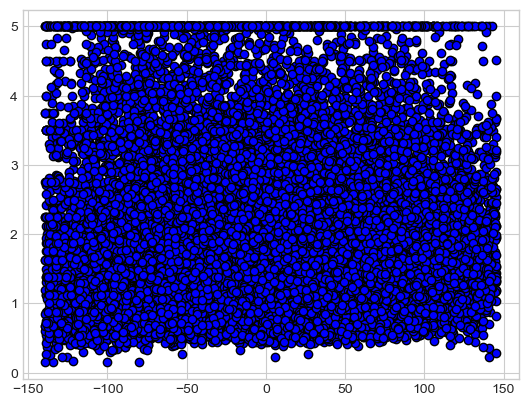

In [37]:
# 그래프에 나타내기 위해 데이터 차원 축소
tsne = TSNE(n_components=1)
X_comp = tsne.fit_transform(X)

# 실제 주택 가격 시각화
plt.scatter(X_comp, y, c="b", edgecolors="k");

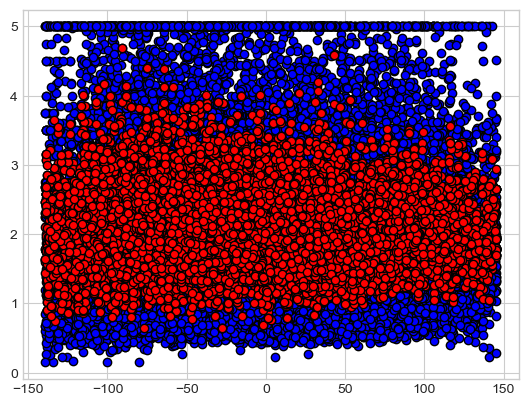

In [38]:
# 차원 축소한 데이터 KNeighborsRegressor 학습
model = KNeighborsRegressor()
model.fit(X_comp, y)
y_predict = model.predict(X_comp)

# 실제 주택 가격
plt.scatter(X_comp, y, c="b", edgecolors="k");

# 예측 주택 가격
plt.scatter(X_comp, y_predict, c="r", edgecolors="k");